In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

In [2]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy = state

    # Update position with current velocity
    new_x = x + vx * dt
    new_y = y + vy * dt

    # Speed stays constant (no acceleration yet)
    new_vx = vx
    new_vy = vy

    return np.array([new_x, new_y, new_vx, new_vy])

In [3]:
def h_x(state):
    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, _, _ = state
    
    # Position of beacons
    beacon0_pos = np.array([-30, 0])
    beacon1_pos = np.array([30, 0])

    # Calculate angle (from the ship) to each beacon (converse from radians ->  angles)
    angle0 = np.arctan2(y - beacon0_pos[1], x - beacon0_pos[0]) * 180 / np.pi
    angle1 = np.arctan2(y - beacon1_pos[1], x - beacon1_pos[0]) * 180 / np.pi

    # Adjust angles to defined orientation (also implement orientation angle later)
    angle0 = (angle0 + 270) % 360
    angle1 = (angle1 + 270) % 360

    return np.array([angle0, angle1])

In [4]:
# Berechne die echten Status der ersten 10 Sekunden
dT = 0.1 # 0.1 sec

states = [np.array([0, -10, 0, 2])] # pos_x, pos_y, vel_x, vel_y (constatn velocity model)

for i in range(1, 100):
    s = states[i - 1] # previous state
    states.append(f_x(s, dT))

In [5]:
# Berechne die verrauschten Messdaten
std_0 = 1.0
std_1 = 1.0

np.random.seed(123456789)

zs = []

for i in range(100):
    state = h_x(states[i]) # winkel beacon0, winkel beacon_1
    zs.append([state[0] + np.random.randn() * std_0, state[1] + np.random.randn() * std_0])

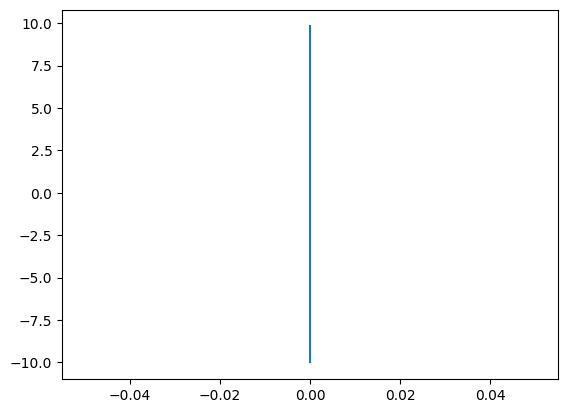

In [6]:
# visualisiere echten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

plt.plot(x_val, y_val)
plt.show()

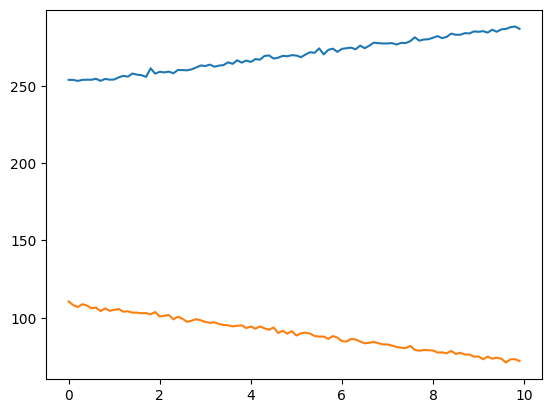

In [7]:
# visualisiere messdaten (diese sind verrauscht)

beacon0_val = [z[0] for z in zs]
beacon1_val = [z[1] for z in zs]
t = [(i * dT) for i in range(100)]

plt.plot(t, beacon0_val)
plt.plot(t, beacon1_val)
plt.show()

In [20]:
# UKF
sigmas = MerweScaledSigmaPoints(4, alpha = 0.1, beta = 2.0, kappa = 1.0)

ukf = UKF(dim_x = 4, dim_z = 2, fx = f_x, hx = h_x, dt = dT, points = sigmas)

ukf.x = states[0]
ukf.R = np.diag([std_0 ** 2, std_1 ** 2])
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt = dT, var = 0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt = dT, var = 0.02)

In [21]:
# bereche position mit UKF

uxs = []

for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())

uxs = np.array(uxs)

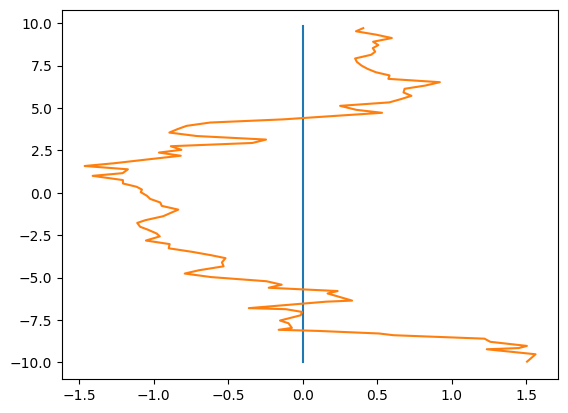

In [23]:
# visualisiere gefilterten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

plt.plot(x_val, y_val)
plt.plot(ux_val, uy_val)
plt.show()